# Loading Climate Policy Radar's open data from the Huggingface Hub

In this notebook we show you how to load our law and policy full text data from the Huggingface Hub, and understand what's in it by walking through an overview of our processing pipeline.

# Loading the data

There are several ways of downloading data from the Huggingface Hub, and [several libraries](https://huggingface.co/docs/hub/en/datasets-libraries) you can use to consume it.

Here we use the `huggingface_hub` SDK to download the data, then `duckdb` to analyse it. 

In [1]:
import duckdb
from huggingface_hub import snapshot_download

/Users/kalyan/Library/Caches/pypoetry/virtualenvs/open-data-cnKQNmjn-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
REPO_NAME = "ClimatePolicyRadar/all-document-text-data"
REPO_URL = f"https://huggingface.co/datasets/{REPO_NAME}"
DATA_CACHE_DIR = "../../cache"

REVISION = "main"  # Use this to set a commit hash. Recommended!

snapshot_download(
    repo_id=REPO_NAME,
    repo_type="dataset",
    local_dir=DATA_CACHE_DIR,
    revision=REVISION,
    allow_patterns=["*.parquet"],
)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 1246.67it/s]


'/Users/kalyan/Documents/CPR/open-data/cache'

In [3]:
db = duckdb.connect()

# Authenticate (needed if loading a private dataset)
# You'll need to log in using `huggingface-cli login` in your terminal first
db.execute("CREATE SECRET hf_token (TYPE HUGGINGFACE, PROVIDER credential_chain);")

# Create a view called 'open_data', and count the number of rows and distinct documents
# in the view
db.execute(
    f"CREATE VIEW open_data AS SELECT * FROM read_parquet('{DATA_CACHE_DIR}/*.parquet')"
)
db.sql("SELECT COUNT(*), COUNT(DISTINCT document_id) FROM open_data")

┌──────────────┬─────────────────────────────┐
│ count_star() │ count(DISTINCT document_id) │
│    int64     │            int64            │
├──────────────┼─────────────────────────────┤
│     21027685 │                        7804 │
└──────────────┴─────────────────────────────┘

## Understanding the data through the creation pipeline

The pipeline to create this data is as follows:

1. Some metadata about the document (its title, date of creation, optional URL...) are provided.
2. If the URL contains a PDF or HTML content type, the document is downloaded and its text is extracted. The language of the text is also detected.
3. The pipeline outputs the document metadata as well as the text and detected language are saved to the dataset.


This can also be visualised.

```mermaid
graph LR
    A["Documents and metadata in"] --> B{"URL present?"}
    B -->|Yes| C["Download source"]
    B -->|No| F["Output document metadata"]
    C --> D["Extract text"]
    D --> E["Output: text, detected language(s), and document metadata"]
    F --> E
```

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

### Viewing all the columns

We can use an SQL query to see all of the columns in the dataset.

In [5]:
db.sql("DESCRIBE open_data").to_df()[["column_name", "column_type"]]

,column_name,column_type
0,document_id,VARCHAR
1,document_metadata.collection_summary,VARCHAR
2,document_metadata.collection_title,VARCHAR
3,document_metadata.corpus_type_name,VARCHAR
4,document_metadata.corpus_import_id,VARCHAR
5,document_metadata.category,VARCHAR
6,document_metadata.date,VARCHAR
7,document_metadata.description,VARCHAR
8,document_metadata.document_title,VARCHAR
9,document_metadata.download_url,VARCHAR


### Finding empty documents

Let's find the documents without a URL, and check that they have no text.

In [6]:
db.sql(
    """
    SELECT document_id, "document_metadata.document_title", "document_metadata.source_url", "text_block.text", "text_block.language"
    FROM open_data 
    WHERE "document_metadata.source_url" is NULL
    """
).to_df()

,document_id,document_metadata.document_title,document_metadata.source_url,text_block.text,text_block.language
0,CCLW.document.i00000387.n0000,None,None,None,None
1,CCLW.document.i00000960.n0000,None,None,None,None
2,CCLW.executive.10011.0,National Strategy for Electric Mobility 2020 -...,None,None,None
3,CCLW.executive.1003.0,Executive Decree No. 2011-423 fixing the opera...,None,None,None
4,CCLW.executive.10034.0,2nd Basic Plan for Climate Change Response,None,None,None
...,...,...,...,...,...
255,CCLW.legislative.8660.0,Law no 002/2014 on sustainable development,None,None,None
256,CCLW.legislative.8676.0,Energy Law (compliant with the EU Third Energy...,None,None,None
257,CCLW.legislative.8694.0,Act 1396/2010 on Production Subsidy for Electr...,None,None,None
258,CCLW.legislative.8697.0,Law on the promotion of electricity generation...,None,None,None


### Summaries of the data

Let's plot a few different visualisations, to view the different corpus types, languages and geographies present in this data.

In [7]:
def convert_to_python_native(value):
    if isinstance(value, np.ndarray):
        # we could use tolist() here but want the downstream values to be hashable
        return str(value)
    elif isinstance(value, np.integer):
        return int(value)
    elif isinstance(value, np.floating):
        return float(value)
    elif isinstance(value, np.bool_):
        return bool(value)
    return value


def get_document_count_by_column(column: str) -> pd.DataFrame:
    query = f"""
    SELECT "{column}", count(distinct document_id)
    FROM open_data
    GROUP BY "{column}"
    ORDER BY count(distinct document_id) DESC
    """

    result_df = db.sql(query).to_df()

    result_df = result_df.applymap(convert_to_python_native)

    result_df = result_df.rename(
        columns=lambda c: "count" if c.startswith("count") else c
    )

    return result_df

/var/folders/nt/2c78pgv94312v7_mmz24h6kc0000gn/T/ipykernel_11054/2460647041.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_df = result_df.applymap(convert_to_python_native)


<Axes: >

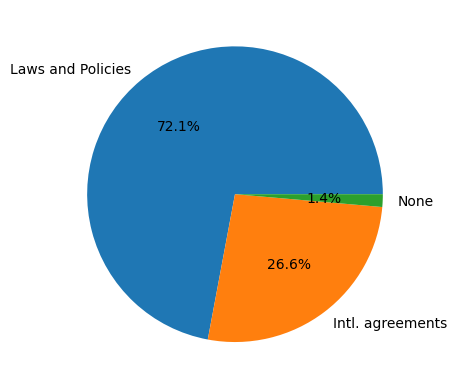

In [8]:
corpus_type_col = "document_metadata.corpus_type_name"

document_count_by_corpus_type = get_document_count_by_column(corpus_type_col)
document_count_by_corpus_type.set_index(corpus_type_col).plot(
    kind="pie", y="count", autopct="%1.1f%%", legend=False, ylabel=""
)

/var/folders/nt/2c78pgv94312v7_mmz24h6kc0000gn/T/ipykernel_11054/2460647041.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_df = result_df.applymap(convert_to_python_native)


Text(0.5, 1.0, 'Document count by languages')

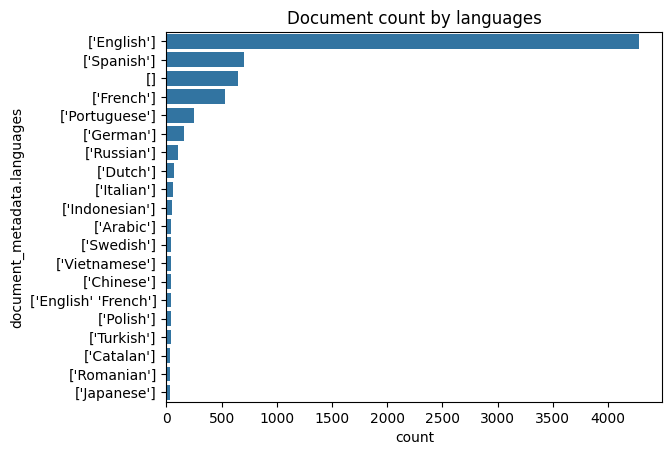

In [9]:
language_col = "document_metadata.languages"
sns.barplot(
    get_document_count_by_column(language_col).head(20), y=language_col, x="count"
).set_title("Document count by languages")

/var/folders/nt/2c78pgv94312v7_mmz24h6kc0000gn/T/ipykernel_11054/2460647041.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_df = result_df.applymap(convert_to_python_native)


Text(0.5, 1.0, 'Document count by geographies')

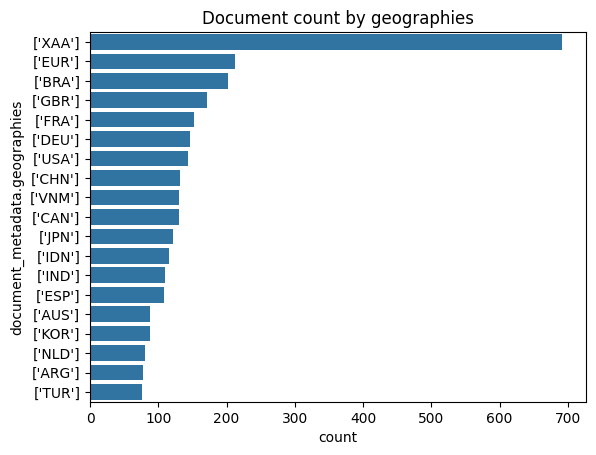

In [10]:
geographies_col = "document_metadata.geographies"
sns.barplot(
    get_document_count_by_column(geographies_col).head(20), y=geographies_col, x="count"
).set_title("Document count by geographies")